In [1]:
###############################################################################
#                               SPCDMPY.py          
#Python modules, functions and data acquisition
############################################################################### 

## Step 0: Import Python Essential Modules
import os
import numpy as np
import sys
from scipy.optimize import fmin_l_bfgs_b
import glob as gb
import matplotlib.pyplot as plt

################################# FUNCTIONS ###################################
## Read the data from MicroMag 2900/3900 Data File (Series 0016.002) only
## Moment vs Time
def readVSM(filename):
### lines: List to read the file line by line.
    lines=[]
### v: matrix with time (s), Moment (Am^2) and Field (T).
    v=np.zeros((1000,3))
    with open(filename,'r',encoding= 'unicode_escape') as fn:
        for linefile in fn:
            lines.append(linefile)
        for i in range(len(lines)):
###Moment at conditioning field (M0 - line 34).
            if i == 33:
                temp=str(lines[i])
                M0=float(temp[30:44])
###Initial (conditioning) field (Bi - line 59).
            if i == 58:
                temp=str(lines[i])
                Bi=float(temp[30:44])
###Final (measuring) field (Bf - line 60).
            if i == 59:
                temp=str(lines[i])
                Bf=float(temp[30:44])
###v matrix (lines 77 to 127, magnetization decay data).
            if i == 76:
                j=0
                k=76
                while j < len(v):
                    temp=str(lines[k])
                    v[j,0:3]=[float(temp[0:13]),float(temp[14:27]),
                     float(temp[29:41])]
                    k += 1
                    j += 1
### Calculating Mq.
                Mq=np.median(v[24:1000,1])
    return M0,Bi,Bf,v,Mq
#-----------------------------------------------------------------------------#
## Read the hysteresis data from MicroMag 2900/3900 Data File (Series 0016.002)
def readH(filename):
### lines: List to read the file line by line.
    lines=[]
    with open(filename,'r',encoding= 'unicode_escape') as fn:
        for linefile in fn:
            lines.append(linefile)
            for i in range(len(lines)):
### Obtaining the Slope Correction (h - line 48).
                if i == 47:
                    temp=str(lines[i])
                    h=float(temp[30:44])
### Obtaining the Saturation (s - line 60).
                if i == 59:
                    temp=str(lines[i])
                    s=float(temp[30:44])
    return h, s
#-----------------------------------------------------------------------------#
## Create the initial random solution (x0)
def IS(Lb,Ub):
### Generating some noise for x0.
    noise=np.random.rand(2)
    x0=np.zeros(len(Lb))
### Using the lower and upper bounds for generating x0.
    for i in range(len(Lb)):
        x0[i]=Lb[i]+(Ub[i]-Lb[i])*noise[i]
    return x0
#-----------------------------------------------------------------------------#
## Calculate the Langevin function
def Langevin(x):
    return ((1.0/np.tanh(x))-(1.0/x))
#-----------------------------------------------------------------------------#
## Forward Problem
def fwd(x):
### T: Temperature (Kelvin).
    T=273+Tm
### Et: Thermal energy (Joule).
    Et=KB*T
### Mc: SP magnetization (A.m^-2).
    Mc=np.zeros(len(Bi))
    for i in range(len(Bi)):
### var1: Moment magnetic product (A.m^2).
        var1=10**(x[0])
### alpha and Mc: Expression (6) from Leite et al. (2018, GJI).
        alpha=(var1*Bi[i])/Et
        Mc[i]=x[1]*Langevin(alpha)
    return Mc
#-----------------------------------------------------------------------------#
## Objective Function
def objf(x):
### Calculating the theoretical SP magnetization through of Forward Problem.
    Mc=fwd(x)
### Mo: Observed SP magnetization (A.m^-2).
    Mo=SP
### Q: residual L-2 norm.
    Q=1000*np.linalg.norm(Mo-Mc,2)
    return Q

In [2]:
###################################################################################
###################################################################################
# PROG01: Data acquisition
## Step 1: Read the current path
print("Welcome to SPCDM Computational Stage!!")
path=os.getcwd()
print("Your current directory is "+path)

## Step 2: Store folders name in a variable
### List all files of the current path
itens=os.listdir(path)
### Create a list (folders) that contained only folder names.
folders=[]
for i in itens:
    if os.path.isdir(i):
        folders.append(i)
print("You have "+str(len(folders))+" folders in this directory")
print("Folders: "+str(folders))

## Step 3: Choose the directory that you want to work and list all files with 
## extension "*.0*"
### flag: variable that compute the folders that are not selected;
### ch: choose option for user (yes=y or no=n)
flag=0
for fl in folders:
    ch=input('Shoud I work on '+str(fl)+'? [y/n]')
### Writting the full path name to change the current directory.
    if ch=="y":
        npath=os.path.join(path,fl)
        os.chdir(npath)
        print("Your new directory is: "+npath)
        break
    if ch=="n":
        flag+=1
        continue  
### Exit the script if no folder is selected.
if flag==len(folders):
    print("No folder was selected.")
    sys.exit("Bye!")
### Change the directory.
os.chdir(npath)
### List and save all filenames with extension ".0*".
data=sorted(gb.glob('*.0*'))

## Step 4: Read the VSM data
### M0: Moment at conditioning field;
### Bi: Initial (conditioning) field;
### Bf: Final (measuring) field;
### Mq: Median magnetization calculated in an interval between
### 0.235 and 10s.
M0=np.zeros(len(data))
Bi=np.zeros(len(data))
Bf=np.zeros(len(data))
Mq=np.zeros(len(data))
for l in range(len(data)):
    m0,bi,bf,v,mq = readVSM(data[l])
    M0[l]=m0; Bi[l]=bi; Bf[l]=bf; t=v[:,0]; do=v[:,1]; Mq[l]=mq

## Step 5: Read the Hysteresis data
### h: Slope correction;
### s: Saturation.
h,s = readH('histerese')

##calculating dia/para correction from slope correction and applying it in M0
#pcor=h*Bi
#M0=M0+pcor

## Step 6: Calculate the SP response and apply the error estimate for each 
## field
### SP: SP Response calculated by difference between M0 and Mq;
### erxp: Experimental error; from calibrator  VSM sample
### err: Error estimate.
SP=M0-Mq
erxp=[0.1955,0.1949,0.1824,0.1871,0.1962,0.2031,0.1905,0.1822,0.1613,0.1661,
      0.1801,0.1812,0.1856,0.1911,0.1961,0.1946,0.1947]
for j in range(len(SP)):
    err=SP*(erxp[j]/100)

Welcome to SPCDM Computational Stage!!
Your current directory is /Volumes/GoogleDrive/Mon Drive/academico/SPCDMpy
You have 9 folders in this directory
Folders: ['nm2', 'nm3', 'nm4', 'nm5', 'nm6', 'PY', '.ipynb_checkpoints', 'matlab', 'nm1']
Shoud I work on nm2? [y/n]y
Your new directory is: /Volumes/GoogleDrive/Mon Drive/academico/SPCDMpy/nm2


%SP parameter: 98.67
%SP parameter1: 1.33
%SP parameter1: 98.67


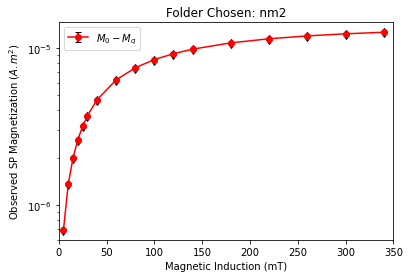

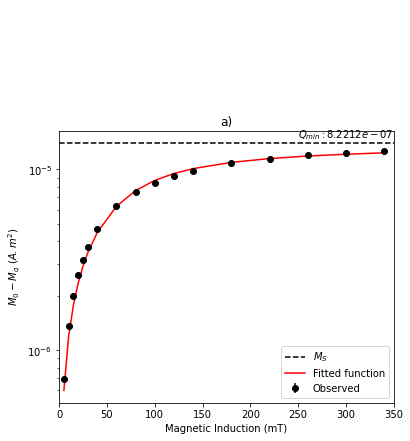

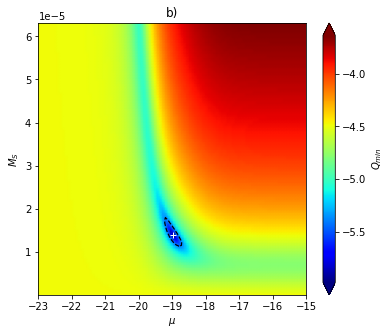

In [3]:
##### Inversion procedure

# PROG02: Data Inversion
## Step 7: Input physical constants
### Tm: Room temperature (Celsius degree);
### KB: Boltzmann constant (J/K).
Tm=25
KB=1.38e-23

## Step 8: Input the bounds of the problem
### mdp: dipole moment associated with the magnetic grain in the SP regime;
### Lb: Lower bound;
### Ub: Upper bound.
mdp=-19.0
Lb=[mdp-4.0,float(max(SP)/1000)]
Ub=[mdp+4.0,float(max(SP)*5)]

## Step 9: Create the initial solution and the function tolerance based on the
## error estimate.
### x0: Inital solution;
### TolFun: Termination tolerance on the function value.
x0=IS(Lb,Ub)
TolFun=np.linalg.norm(err,2)

## Step 10: Calculate the inversion solution from data
### sol: Estimated position of the minimum;
### fval: Value of function at the minimum;
### info: Information dictionary;
sol,fval,info=fmin_l_bfgs_b(objf,x0,approx_grad=True,bounds=(Lb,Ub),
                            factr=TolFun,iprint=0,maxiter=100)
### MU: Magnetic Moment calculated product(A.m^2);
### MS: Saturation magnetization (A.m^-1);
### NP: Concentration of magnetic grains in the sample 
MU=10**sol[0]
MS=sol[1]
NP=MS/MU

## Step 11: Compare the results between the calculated and the observed data
### Mc: SP theoretical magnetization (A.m^-2);
### Qmin: residual L-2 norm at the minimal solution.
Mc=fwd(sol)
Qmin=objf(sol)/1000

#############################################################################
#############################################################################
# PROG03: Parameters to map the Objective Function (Figure 3)
### m_mu: Coordinates of the Magnetic Moment product on map;
### m_ms: Coordinates of the Saturation magnetization on map;
### objmap: Values of objective function in a contour map.
m_mu=np.linspace(Lb[0],Ub[0],100)
m_ms=np.linspace(Lb[1],Ub[1],100)
objmap=np.zeros((len(m_mu),len(m_ms)))

## Step 12: Calculate the values of objmap for MU and MS inside the lower and 
## upper bounds.
for i in range(len(objmap)):
    xi=m_mu[i]
    for j in range(len(objmap[0])):
        yi=m_ms[j]
        pp=[xi,yi]
        objmap[j,i]=objf(pp)/1000


#############################################################################
#############################################################################        
# PROG04: Calculates the %SP concentration related to its fraction of the
# saturation magnetization
### Bs: Saturation field used (T);
### Et: Thermal energy (Joule).
Bs=1
Et=KB*(273+Tm)

## Step 13: Calculate the Magnetization for the sample exposed in saturation 
## field using the parameters from the inversion (Mrs).
### alpha: Internal product for the Langevin function;
### L: Langevin function;
alpha=(MU*Bs)/Et
L=Langevin(alpha)
Mrs=MS*L

## Step 14: Obtaining the contribution of the SP fraction in total magnetizati-
## on (SPcon)
SPcon=(Mrs/s)*100
SPcon1=((s-Mrs)/s)*100
SPcon2=100-(((s-Mrs)/s)*100)
print('%SP parameter: ' '{:.2f}'.format(SPcon))
print('%SP parameter1: ' '{:.2f}'.format(SPcon1))
print('%SP parameter1: ' '{:.2f}'.format(SPcon2))

#############################################################################
#############################################################################
##Saving figures and results
results=[MU,MS,NP,Qmin,SPcon]
np.savetxt("results.txt",results)

## FIGURE 1: Result of Observed SP Magnetization (SP=M0 - Mq)
#plt.figure(1,figsize=(5,5))
plt.figure(1,figsize=(6,4))
plt.errorbar(1000*Bi,SP,err,fmt='-or',ecolor='k',lolims=True, uplims=True,
             label="$ M_0 - M_q$")
plt.yscale('log')
plt.xlim([0,350])
#plt.ylim([1e-7,1e-5])
plt.gca().set_aspect('auto', adjustable='box')
plt.title("Folder Chosen: %s" %fl)
plt.xlabel("Magnetic Induction (mT)")
plt.ylabel("Observed SP Magnetization ($ A.m^2 $)")
plt.legend()
plt.savefig("Figure1.pdf",dpi=300)

## FIGURE 2: Comparation between the observed and calculated responses
### Create a list with strings to print in the figure
result=[np.format_float_scientific(MU, unique=False, precision=4),
        np.format_float_scientific(MS, unique=False, precision=4),
        np.format_float_scientific(NP, unique=False, precision=4),
        np.format_float_scientific(Qmin, unique=False, precision=4)]
### Plot the figure
plt.figure(2,figsize=(6,5))
plt.errorbar(1000*Bi,SP,err,fmt='ok',label="Observed")
plt.yscale('log')
plt.xlim([0,350])
#plt.ylim([1e-7,1e-4])
plt.gca().set_aspect('auto', adjustable='box')
plt.semilogy([0,350],[MS,MS],'--k',label="$M_{S}$")
plt.semilogy(1000*Bi,Mc,'-r',label="Fitted function")
plt.title("a)")
plt.xlabel("Magnetic Induction (mT)")
plt.ylabel("$M_{0}-M_{q}$ ($ A.m^2 $)")
plt.annotate('$\mu: %s$' %result[0],xy=(250, 7e-5))
plt.annotate('$M_{S}: %s$' %result[1],xy=(250,4e-5))
plt.annotate('$N: %s$' %result[2],xy=(250,2.5e-5))
plt.annotate('$Q_{min}: %s$' %result[3],xy=(250,1.5e-5))
plt.legend(loc='lower right')
plt.savefig("Figure2.pdf",dpi=300)

## FIGURE 3: Map of the objective function (PROG03)
plt.figure(3,figsize=(6,5))
f=plt.pcolormesh(m_mu,m_ms,np.log10(objmap),cmap='jet',shading='gouraud')
plt.ticklabel_format(axis="y", style="sci",scilimits=(5,6))
plt.plot(sol[0],sol[1],'+w',markersize=6)
plt.contour(m_mu,m_ms,np.log10(objmap),[np.log10(Qmin),np.log10(5*Qmin)],
            colors='k',linewidths=1.2,linestyles='--')
plt.colorbar(f,extend='both',label='$ Q_{min}$')
plt.title("b)")
plt.xlabel('$ \mu $')
plt.ylabel('$ M_{S} $')
plt.savefig("Figure3.pdf",dpi=300)
plt.show()